In [1]:
# imports
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import os
import numpy as np
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from functools import partial

path = os.path.dirname(os.getcwd())
os.chdir(path)

from src.BayesIMP import *
from src.causalKLGP import *
from src.kernels import *
from src.GP_utils import *
from src.training_utils import *
from src.kernel_utils import *
from src.dgps import *

### Drawing data

In [2]:
# DGP set up
torch.random.manual_seed(1)
d = 1
train_samples = 100
test_samples = 1000
noise = 0.1

# PLotting settings
z_val = 1.96

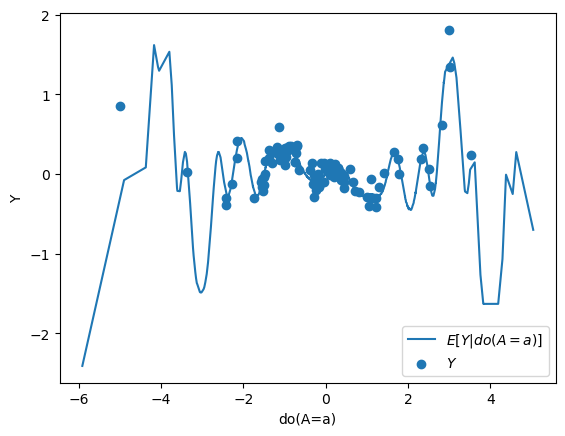

In [3]:
# Dataset generation and plotting E[Y|do(A)]
torch.random.manual_seed(1)

A, V, Y,doA, VdoA, YdoA, EYdoA = BayesIMP_Abelation(train_samples,test_samples,1.5,noise,noise)
Y = Y.reshape(len(Y),)
# Plot
indices = torch.argsort(doA,0)[:,0]
indices_train = torch.argsort(A,0)[:,0]
plt.plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A=a)]$")
plt.scatter(A,Y, label = r"$Y$")
plt.xlabel("do(A=a)")
plt.ylabel("Y")
plt.legend()
plt.show()

### Running BayesIMP

In [4]:
nulist = 2**torch.linspace(-2,2,3)*(V.var()**0.5)
print(nulist)


"""
Training P(Y|V)
"""
learn_rate = 0.1
n_iter = 500
n = train_samples

Kernels_V = []
Noise_Y =  []
Loss_Y = []

for k in range(len(nulist)):
    nu = torch.tensor([nulist[k]]).requires_grad_(False)
    
    # Initialisation
    kernel_V_scale = torch.tensor([1.0], requires_grad = True)
    kernel_V_ls = torch.tensor([d**0.5*1.0]).repeat(d).requires_grad_(True)
    noise_Y = torch.tensor([-2.0],requires_grad = True).float()
    kernel_V = NuclearGaussianKernel(lengthscale = kernel_V_ls,
                                     scale = kernel_V_scale,
                                     sigma = nu)
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_V.lengthscale,
                                  kernel_V.scale,
                                  kernel_V.sigma,
                                  noise_Y], lr=learn_rate)
    Losses = torch.zeros(n_iter)

    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -GPML(Y, V, kernel_V, torch.exp(noise_Y))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
                print("iter {0} loss: ".format(i), Losses[i])

    # Storing
    Kernels_V.append(kernel_V)
    Noise_Y.append(torch.exp(noise_Y))
    Loss_Y.append(Losses[-1])

tensor([0.2515, 1.0062, 4.0247])
iter 0 loss:  tensor(26.0428)
iter 100 loss:  tensor(17.7548)
iter 200 loss:  tensor(17.7546)
iter 300 loss:  tensor(17.7546)
iter 400 loss:  tensor(17.7546)
iter 0 loss:  tensor(21.4340)
iter 100 loss:  tensor(-62.2750)
iter 200 loss:  tensor(-62.7220)
iter 300 loss:  tensor(-62.5105)
iter 400 loss:  tensor(-62.4963)
iter 0 loss:  tensor(12.1987)
iter 100 loss:  tensor(-70.7269)
iter 200 loss:  tensor(-70.7287)
iter 300 loss:  tensor(-70.7285)
iter 400 loss:  tensor(-70.7281)


In [5]:
"""
Training P(V|A)
"""
learn_rate = 0.1
n_iter=500

Kernels_A = []
Noise_feat =  []
Loss_feat = []

for k in range(len(nulist)):
    nu = Kernels_V[k].sigma
    
    # Initialisation
    med_heur = median_heuristic(A)
    kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),
                              scale = torch.tensor([1.0], requires_grad = True))
    noise_feat = torch.tensor(-2.0, requires_grad = True)
    
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_A.scale,noise_feat], lr=learn_rate)
    Losses = torch.zeros(n_iter)
    
    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss =  -GPfeatureML(V, A, kernel_V, kernel_A, torch.exp(noise_feat))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
            print("iter {0} loss: ".format(i), Losses[i])
    
    # Storing
    Kernels_A.append(kernel_A)
    Noise_feat.append(torch.exp(noise_feat))     
    Loss_feat.append(Losses[-1])

/tmp/ipykernel_251379/3439485288.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),


iter 0 loss:  tensor(-49992.8398)
iter 100 loss:  tensor(-54554.)
iter 200 loss:  tensor(-54554.0547)
iter 300 loss:  tensor(-54554.0703)
iter 400 loss:  tensor(-54554.0547)
iter 0 loss:  tensor(-49992.8398)
iter 100 loss:  tensor(-54554.)
iter 200 loss:  tensor(-54554.0547)
iter 300 loss:  tensor(-54554.0703)
iter 400 loss:  tensor(-54554.0547)
iter 0 loss:  tensor(-49992.8398)
iter 100 loss:  tensor(-54554.)
iter 200 loss:  tensor(-54554.0547)
iter 300 loss:  tensor(-54554.0703)
iter 400 loss:  tensor(-54554.0547)


/nfs/ghome/live/danceh/Causal-GP/causal-KL-GP/src/BayesIMP.py:55: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1724888750493/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  V2 = alpha_y.T @ R_vv @ KinvR @ KinvR @ alpha_y * kpost_atest_approx


nu =  tensor(0.2515) negMLL(Y) =  tensor(17.7546)
Calibration level for 95% CI (f) :  tensor(0.7290)
Calibration level for 95% CI (y):  tensor(0.8670)
nu =  tensor(1.0062) negMLL(Y) =  tensor(-62.2759)
Calibration level for 95% CI (f) :  tensor(0.9740)
Calibration level for 95% CI (y):  tensor(0.9775)
nu =  tensor(4.0247) negMLL(Y) =  tensor(-70.7286)
Calibration level for 95% CI (f) :  tensor(0.9270)
Calibration level for 95% CI (y):  tensor(0.9584)


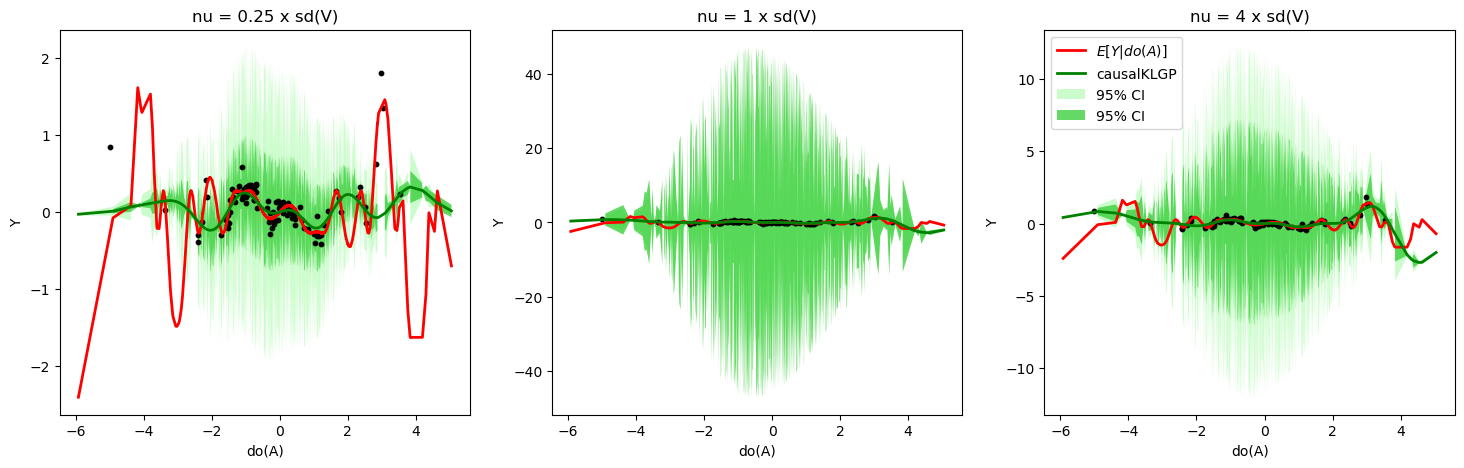

In [6]:
# Getting posterior moments and plotting results
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

for k in range(len(nulist)):
    kernel_A = Kernels_A[k]
    kernel_V = Kernels_V[k]
    noise_Y = Noise_Y[k]
    noise_feat = Noise_feat[k]
    loss_y = Loss_Y[k]

    
    # getting post mean predictions
    Bayesimp = BayesIMP(kernel_A, kernel_V, [], noise_Y, noise_feat)
    Bayesimp_mu = Bayesimp.post_mean(Y, A, V, doA).detach()
    Bayesimp_var = Bayesimp.post_var(Y, A, V, doA, reg = 1e-3).detach()
    Bayesimp_var_noise = Bayesimp.post_var(Y, A, V, doA, reg = 1e-3, latent = False).detach()
    
     # Getting CI
    indices = torch.argsort(doA,0)[:,0]
    indices_train = torch.argsort(A,0)[:,0]
    Upper = (Bayesimp_mu[indices]+z_val*torch.sqrt(torch.diag(Bayesimp_var[indices])))
    Lower = (Bayesimp_mu[indices]-z_val*torch.sqrt(torch.diag(Bayesimp_var[indices])))
    Upper_noise = (Bayesimp_mu[indices]+z_val*torch.sqrt(torch.diag(Bayesimp_var_noise[indices])))
    Lower_noise = (Bayesimp_mu[indices]-z_val*torch.sqrt(torch.diag(Bayesimp_var_noise[indices])))
    print("nu = ", nulist[k], "negMLL(Y) = ", loss_y)

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],Bayesimp_mu[indices], label = r"causalKLGP", color = "green", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise,Lower_noise, color = "palegreen",alpha=0.5, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper,Lower, color = "limegreen",alpha=0.75, edgecolor='none', label = "95% CI")
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str(2**(-2+2*k))+" x sd(V)")

    inds = (doA[:,0]<=1)*(doA[:,0]>=0)
    inds = inds*0==0
    print("Calibration level for 95% CI (f) : ",((EYdoA[inds] <= Upper[inds])*(EYdoA[inds]>=Lower[inds])).float().mean())
    print("Calibration level for 95% CI (y): ",((YdoA[inds] <= Upper_noise[inds])*(YdoA[inds]>=Lower_noise[inds])).float().mean())
plt.legend()
plt.show()
#fig.savefig("d={0}_Bayesimp".format(d), bbox_inches = "tight")

### Implementing our method

In [7]:
power_list = torch.linspace(-2,2,3)
nulist = 2**power_list*(V.var()**0.5)
print(nulist)


"""
Training P(Y|V)
"""
learn_rate = 0.1
n_iter = 500
n = train_samples

Kernels_V = []
Noise_Y =  []
Loss_Y = []

for k in range(len(nulist)):
    nu = torch.tensor([nulist[k]]).requires_grad_(False)
    
    # Initialisation
    kernel_V_scale = torch.tensor([1.0], requires_grad = True)
    kernel_V_ls = torch.tensor([d**0.5*1.0]).repeat(d).requires_grad_(True)
    noise_Y = torch.tensor([-2.0],requires_grad = True).float()
    kernel_V = GaussianKernel(lengthscale = kernel_V_ls,
                                     scale = kernel_V_scale)
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_V.lengthscale,
                                  kernel_V.scale,
                                  noise_Y], lr=learn_rate)
    Losses = torch.zeros(n_iter)

    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss = -GPML(Y, V, kernel_V, torch.exp(noise_Y))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
                print("iter {0} loss: ".format(i), Losses[i])

    # Storing
    Kernels_V.append(ApproximateNuclearKernel(kernel_V,
                                             dist = Normal(torch.zeros(V.size()[1]), nu*torch.ones(V.size()[1])),
                                             samples = 10**5)
                                             )
    Noise_Y.append(torch.exp(noise_Y))
    Loss_Y.append(Losses[-1])

tensor([0.2515, 1.0062, 4.0247])
iter 0 loss:  tensor(8.9991)
iter 100 loss:  tensor(-71.2196)
iter 200 loss:  tensor(-71.2214)
iter 300 loss:  tensor(-71.2205)
iter 400 loss:  tensor(-71.2208)
iter 0 loss:  tensor(8.9991)
iter 100 loss:  tensor(-71.2196)
iter 200 loss:  tensor(-71.2214)
iter 300 loss:  tensor(-71.2205)
iter 400 loss:  tensor(-71.2208)
iter 0 loss:  tensor(8.9991)
iter 100 loss:  tensor(-71.2196)
iter 200 loss:  tensor(-71.2214)
iter 300 loss:  tensor(-71.2205)
iter 400 loss:  tensor(-71.2208)


In [8]:
"""
Training P(V|A)
"""
learn_rate = 0.1
n_iter=500

Kernels_A = []
Noise_feat =  []
Loss_feat = []

for k in range(len(nulist)):
    nu = nulist[k]
    kernel_V = Kernels_V[k]
    
    # Initialisation
    med_heur = median_heuristic(A)
    kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),
                              scale = torch.tensor([1.0], requires_grad = True))
    noise_feat = torch.tensor(-2.0, requires_grad = True)
    
    # Optimiser set up
    optimizer = torch.optim.Adam([kernel_A.scale,noise_feat], lr=learn_rate)
    Losses = torch.zeros(n_iter)
    
    # Updates
    for i in range(n_iter):
        optimizer.zero_grad()
        loss =  -GPmercerML(V, A, kernel_V, kernel_A, torch.exp(noise_feat))
        Losses[i] = loss.detach()
        loss.backward()
        optimizer.step()
        if not i % 100:
            print("iter {0} loss: ".format(i), Losses[i])
    
    # Storing
    Kernels_A.append(kernel_A)
    Noise_feat.append(torch.exp(noise_feat))     
    Loss_feat.append(Losses[-1])

/tmp/ipykernel_251379/1242576073.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel_A = GaussianKernel(lengthscale = torch.tensor(med_heur, requires_grad = True),


iter 0 loss:  tensor(-79.5210)
iter 100 loss:  tensor(-152.1657)
iter 200 loss:  tensor(-156.5243)
iter 300 loss:  tensor(-158.8144)
iter 400 loss:  tensor(-159.4112)
iter 0 loss:  tensor(-79.5210)
iter 100 loss:  tensor(-152.1657)
iter 200 loss:  tensor(-156.5243)
iter 300 loss:  tensor(-158.8144)
iter 400 loss:  tensor(-159.4112)
iter 0 loss:  tensor(-79.5210)
iter 100 loss:  tensor(-152.1657)
iter 200 loss:  tensor(-156.5243)
iter 300 loss:  tensor(-158.8144)
iter 400 loss:  tensor(-159.4112)


nu =  tensor(0.2515) negMLL(Y) =  tensor(-71.2203)
Calibration level for 95% CI (f) :  tensor(0.5811)
Calibration level for 95% CI (y):  tensor(0.5147)
nu =  tensor(1.0062) negMLL(Y) =  tensor(-71.2203)
Calibration level for 95% CI (f) :  tensor(0.6013)
Calibration level for 95% CI (y):  tensor(0.5277)
nu =  tensor(4.0247) negMLL(Y) =  tensor(-71.2203)
Calibration level for 95% CI (f) :  tensor(0.8465)
Calibration level for 95% CI (y):  tensor(0.6876)


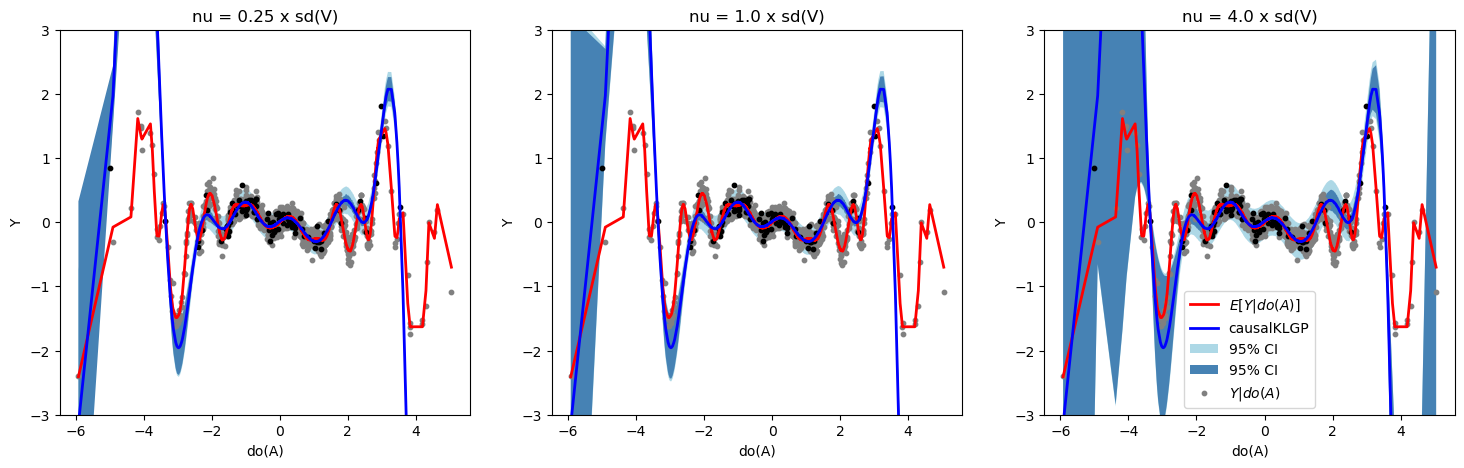

In [14]:
# Getting posterior moments and plotting results
fig,axs = plt.subplots(1,len(nulist),figsize = (18,5))

for k in range(len(nulist)):
    kernel_A = Kernels_A[k]
    kernel_V = Kernels_V[k]
    noise_Y = Noise_Y[k]
    noise_feat = Noise_feat[k]
    loss_y = Loss_Y[k]

    
    # getting post mean predictions
    causalklgp = causalKLGP(kernel_A, kernel_V, [], noise_Y, noise_feat)
    causalklgp_mu = causalklgp.post_mean(Y, A, V, doA).detach()
    causalklgp_var = causalklgp.post_var(Y, A, V, doA, reg = 1e-3, latent = True).detach()
    causalklgp_var_noise = causalklgp.post_var(Y, A, V, doA, reg = 1e-3, latent = False).detach()
    
    # Getting CI
    Upper = (causalklgp_mu+z_val*torch.sqrt(torch.diag(causalklgp_var)))
    Lower = (causalklgp_mu-z_val*torch.sqrt(torch.diag(causalklgp_var)))
    Upper_noise = (causalklgp_mu+z_val*torch.sqrt(torch.diag(causalklgp_var_noise)))
    Lower_noise = (causalklgp_mu-z_val*torch.sqrt(torch.diag(causalklgp_var_noise)))
    print("nu = ", nulist[k], "negMLL(Y) = ", loss_y)

    axs[k].plot(doA[indices],EYdoA[indices], label = r"$ E[Y|do(A)]$", color = "red", linewidth = 2)
    axs[k].plot(doA[indices],causalklgp_mu[indices], label = r"causalKLGP", color = "blue", linewidth = 2)
    axs[k].fill_between(doA[indices][:,0],Upper_noise[indices],Lower_noise[indices], color = "lightblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].fill_between(doA[indices][:,0],Upper[indices],Lower[indices], color = "steelblue",alpha=1, edgecolor='none', label = "95% CI")
    axs[k].scatter(doA[indices],YdoA[indices], label = r"$ Y|do(A)$", color = "grey", s=10, alpha = 1)
    axs[k].scatter(A,Y, s = 10, color = "black")
    axs[k].set_xlabel("do(A)")
    axs[k].set_ylabel("Y")
    axs[k].set_title("nu = " + str((2**power_list[k]).item())+" x sd(V)")
    axs[k].set_ylim(-3,3)
    
    inds = (doA[:,0]<=2)*(doA[:,0]>=-2)
    #inds = inds*0==0
    print("Calibration level for 95% CI (f) : ",((EYdoA[inds] <= Upper[inds])*(EYdoA[inds]>=Lower[inds])).float().mean())
    print("Calibration level for 95% CI (y): ",((YdoA[inds] <= Upper_noise[inds])*(YdoA[inds]>=Lower_noise[inds])).float().mean())

plt.legend()
plt.show()
#fig.savefig("d={0}_Bayesimp".format(d), bbox_inches = "tight")

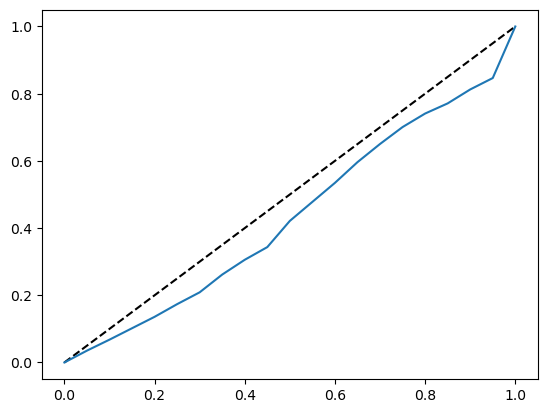

In [29]:
# Getting calibration levels
inds = (doA[:,0]<=2)*(doA[:,0]>=-2)

mean = causalklgp_mu[:,None]
var = causalklgp_var.diag()[:,None]

levels = torch.linspace(0,1,21)[:,None]
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
posterior_fraction = ((EYdoA[inds,None] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)

plt.plot(levels, levels, ls = "dashed", color = "black")
plt.plot(levels,posterior_fraction)

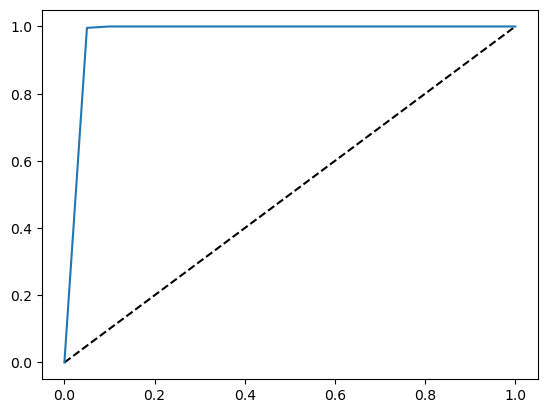

In [28]:
# Getting calibration levels
inds = (doA[:,0]<=1)*(doA[:,0]>=0)

mean = Bayesimp_mu[:,None]
var = Bayesimp_var_noise.diag()[:,None]

levels = torch.linspace(0,1,21)[:,None]
z_quantiles = Normal(0, 1).icdf(1-(1-levels)/2)
posterior_fraction = ((YdoA[inds] - mean[inds]).abs() <= var[inds]**0.5 @ z_quantiles.T).float().mean(0)

plt.plot(levels, levels, ls = "dashed", color = "black")
plt.plot(levels,posterior_fraction)